### Company XYZ is an Online Travel Agent site, such as Expedia, Booking.com, etc. They haven't invested in data science yet and all the data they have about user searches are simply stored in the URLs generated when users search for a hotel. If you are not familiar with URLs, you can run a search on any OTA site and see how all search parameters are present in the URL.
### You are asked to:
#### (1) Create a clean data set where each column is a field in the URL, each row is a given search and the cells are the corresponding URL values.
#### (2) For each search query, how many amenities were selected?
#### (3) Often, to measure the quality of a search algorithm, data scientists use some metric based on how often users click on the second page, third page, and so on. The idea here is that a great search algorithm should return all interesting results on the first page and never force users to visit the other pages (how often do you click on the second page results when you search on Google? Almost never, right?). Create a metric based on the above idea and find the city with the worst search algorithm.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 350)

from urllib.parse import urlparse

import seaborn as sns
import matplotlib.pyplot as plt

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

### Read in the data set

In [2]:
url = pd.read_csv("../Datasets/url_list.txt", sep = " ", header = None)
print(url.shape)
url.head()

(77677, 1)


,0
0,http://www.mysearchforhotels.com/shop/hotelsea...
1,http://www.mysearchforhotels.com/shop/hotelsea...
2,http://www.mysearchforhotels.com/shop/hotelsea...
3,http://www.mysearchforhotels.com/shop/hotelsea...
4,http://www.mysearchforhotels.com/shop/hotelsea...


### Data processing

In [3]:
def search_parse(dat):
    """ function to parse users" search history """
    n = len(dat)
    col_names = ["checkin", "checkout", "customMinimumPriceFilter", "customMaximumPriceFilter", "freeCancellation",
                 "stars_5", "stars_4", "stars_3", "stars_2", "stars_1", "max_score", "min_score", "couponCode",
                 "adults", "city", "children", "amenities", "search_page"]
    
    search_maps = {}
    for name in col_names:
        search_maps[name] = [np.nan] * n
          
    for i in range(n):
        search_conditions = urlparse(dat.iloc[i][0])[4]
        items = search_conditions.split("&")
        conditions = set()
        
        for item in items:
            key, value = item.split("=")
            key = key.split(".")[1]
            if key == "city":
                value = value.strip().replace("+", " ")
            if key not in conditions:
                search_maps[key][i] = value
                conditions.add(key)
            else:
                search_maps[key][i] = search_maps[key][i] + ", " + value
            
    search_dat = pd.DataFrame(search_maps, columns = col_names)
    search_dat["checkin"] = pd.to_datetime(search_dat["checkin"])
    search_dat["checkout"] = pd.to_datetime(search_dat["checkout"])
    search_dat = search_dat.rename(columns = {"customMinimumPriceFilter": "minPrice",
                                              "customMaximumPriceFilter": "maxPrice"})
    return search_dat

In [4]:
search_dat = search_parse(dat = url)

#### (1) Create a clean data set where each column is a field in the URL, each row is a given search and the cells are the corresponding URL values.

In [5]:
search_dat.head()

,checkin,checkout,minPrice,maxPrice,freeCancellation,...,adults,city,children,amenities,search_page
0,2015-09-19,2015-09-20,NaN,NaN,NaN,...,3,"New York, NY, United States",NaN,NaN,1
1,2015-09-14,2015-09-15,NaN,NaN,NaN,...,3,"London, United Kingdom",NaN,NaN,1
2,2015-09-26,2015-09-27,NaN,175,NaN,...,2,"New York, NY, United States",NaN,NaN,1
3,2015-09-02,2015-09-03,NaN,NaN,NaN,...,1,"Hong Kong, Hong Kong",NaN,NaN,1
4,2015-09-20,2015-09-29,NaN,275,NaN,...,3,"London, United Kingdom",NaN,NaN,1


#### (2) For each search query, how many amenities were selected?

In [6]:
search_dat["amenities"].value_counts()

internet                272
yes_smoking             170
shuttle                 111
yes_pet                  85
breakfast                39
lounge                   22
yes_smoking, yes_pet      4
breakfast, yes_pet        1
Name: amenities, dtype: int64

In [7]:
search_dat["amenities_count"] = search_dat["amenities"].apply(lambda x: 0 if pd.isnull(x) else len(x.split(", ")))
search_dat["amenities_count"].value_counts()

0    76973
1      699
2        5
Name: amenities_count, dtype: int64

#### (3) Often, to measure the quality of a search algorithm, data scientists use some metric based on how often users click on the second page, third page, and so on. The idea here is that a great search algorithm should return all interesting results on the first page and never force users to visit the other pages (how often do you click on the second page results when you search on Google? Almost never, right?). Create a metric based on the above idea and find the city with the worst search algorithm.

In [8]:
search_dat["first_page_flag"] = search_dat["search_page"].apply(lambda x: 1.0 if x == "1" else 0.0)
search_dat.head()

,checkin,checkout,minPrice,maxPrice,freeCancellation,...,children,amenities,search_page,amenities_count,first_page_flag
0,2015-09-19,2015-09-20,NaN,NaN,NaN,...,NaN,NaN,1,0,1.0
1,2015-09-14,2015-09-15,NaN,NaN,NaN,...,NaN,NaN,1,0,1.0
2,2015-09-26,2015-09-27,NaN,175,NaN,...,NaN,NaN,1,0,1.0
3,2015-09-02,2015-09-03,NaN,NaN,NaN,...,NaN,NaN,1,0,1.0
4,2015-09-20,2015-09-29,NaN,275,NaN,...,NaN,NaN,1,0,1.0


In [9]:
list(search_dat.columns)

['checkin',
 'checkout',
 'minPrice',
 'maxPrice',
 'freeCancellation',
 'stars_5',
 'stars_4',
 'stars_3',
 'stars_2',
 'stars_1',
 'max_score',
 'min_score',
 'couponCode',
 'adults',
 'city',
 'children',
 'amenities',
 'search_page',
 'amenities_count',
 'first_page_flag']

                                       city  first_page_flag
1                    London, United Kingdom         0.526588
2               New York, NY, United States         0.557616
0                      Hong Kong, Hong Kong         0.910826
3  San Francisco, California, United States         0.959285


Text(0, 0.5, 'First Page Rate ')

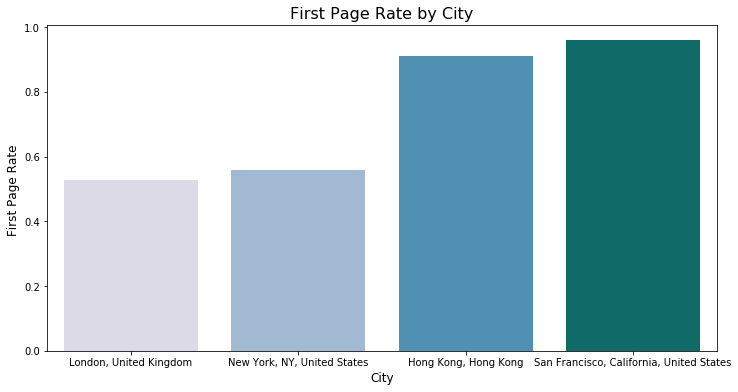

In [10]:
grp_city = search_dat[["city", "first_page_flag"]].groupby("city").mean().reset_index().sort_values(by = "first_page_flag")
print(grp_city)
plt.figure(figsize = [12, 6])
sns.barplot(x = "city", y = "first_page_flag", data = grp_city, palette = "PuBuGn")
plt.title("First Page Rate by City", fontsize = 16)
plt.xlabel("City", fontsize = 12)
plt.ylabel("First Page Rate ", fontsize = 12)

London and New York city have the worst search algorithm.